# Feasibility-driven trust Region Bayesian Optimization (FuRBO)

- Contributors: paoloascia, elenaraponi
- Last update 19 December 2025
- BoTorch version: 0.16.1

In this tutorial, we show how to implement the Feasibility-driven trust Region Bayesian Optimization (FuRBO) [1] algorithm in a closed loop, with restarts. This is a Bayesian optimization (BO) algorithm developed specifically to handle severely constrained problems, while still performing well in simpler settings. 

The key feature of FuRBO is the new definition of the trust region. At each iteration, we define the trust regions as a hyper-rectangle encapsulating subregions of the search space predicted to be promising by the Gaussian process regression (GPR) models of the objective and constraints. Compared to other trust-region-based methods, such as Scalable Constrained Bayesian Optimization (SCBO) [2], FuRBO offers higher flexibility in how the trust region evolves. Its position and shape adapt dynamically to the regions predicted to be both feasible and optimal, allowing the search to align with the structure of the GP models.

In case of mildly constrained scenarios, the new definition of the trust region is advantageous when several samples are evaluated at each iteration (batches). 

Therefore, we recommend using FuRBO when solving:
  - high-dimensional constrained black-box problems;
  - severely constrained black-box problems of any dimension D;
  - constrained problems evaluated with large batch sizes (i.e., bigger than 1D).

[1] [Paolo Ascia, Elena Raponi, Thomas Bäck and Fabian Duddeck. "Feasibility-Driven Trust Region Bayesian Optimization." In AutoML 2025 Methods Track.](https://doi.org/10.48550/arXiv.2506.14619)

[2] [David Eriksson and Matthias Poloczek. Scalable constrained Bayesian optimization. In International Conference on Artificial Intelligence and Statistics, pages 730–738. PMLR, 2021.](https://doi.org/10.48550/arxiv.2002.08526)


![Graphical abstract](graphical_abstract_furbo.png)

## Tutorial on FuRBO

Tho show the implementation of FuRBO, we use a 20D Ackley function on the domain $[−5,10]^{10}$ subject to two constraint functions $c_1$ and $c_2$. The problem maximizes the Ackley function under the constraints $c_1(x) \leq 0$ and $c_2(x) \leq 0$. The Ackley function is translated in every dimension, so that the optimum of the unconstrained problem lies outside of the feasible area. Since this problem presents only two constraints, we showcase the performance with a batch of $q = 3D = 30$.

### Objective function

In this block, we define a handle to evaluate the objective function.

In [3]:
import torch
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize

import warnings

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
tkwargs = {"device": device, "dtype": dtype}

warnings.filterwarnings("ignore")

# Defining objective function
fun = Ackley(dim=10, negate=True).to(**tkwargs)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))


### Constraint functions

The problem is constrained by two functions, $c_1$ and $c_2$. In this block, we define the constriant functions and a handle to call when evaluating the constraints.


1. Constraint $c_1$: enforce the $\sum_{i=1}^{10} x_i \leq 0$. 

In [4]:
def c1(x):
    return x.sum()

2. Constraint $c_2$: enforce the $l_2$ norm $\| \mathbb{x}\|_2 \leq 0.5$.

In [5]:
def c2(x):
    return torch.norm(x, p=2) - 5
    
def eval_constraints(x):
    """This is a helper function we use to unnormalize and evalaute a point on the constraints"""
    return Tensor([c1(unnormalize(x - 0.3, fun.bounds)), c2(unnormalize(x - 0.3, fun.bounds))])

### FuRBO Class
We define a class to hold the information needed for the optimization loop. 

The state is updated with the samples evaluated at each iteration. Therefore, the class presents a method for self-updating.

Prior to the class, two utility functions are defined. The first one identifies the current best sample, while the second one fits a GPR model to the current dataset. 

The ```FurboState``` class features a function to reset the status when restarting. Notice that the state is emptied when restarting. Therefore the samples previously evaluated are extracted and saved (see main optimization loop).

In [6]:
import gpytorch

from botorch.fit import fit_gpytorch_mll

from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms import Normalize
from botorch.models.model_list_gp_regression import ModelListGP

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from torch.quasirandom import SobolEngine

from torch import Tensor

def get_best_index_for_batch(n_tr, Y: Tensor, C: Tensor):
    """Return the index for the best point. One for each trust region.
    For reference, see https://botorch.org/docs/tutorials/scalable_constrained_bo/"""
    is_feas = (C <= 0).all(dim=-1)
    if is_feas.any():  # Choose best feasible candidate
        score = Y.clone()
        score[~is_feas] = -float("inf")
        return torch.topk(score.reshape(-1), k=n_tr).indices
    return torch.topk(C.clamp(min=0).sum(dim=-1), k=n_tr, largest=False).indices # Return smallest violation

def get_fitted_model(X, Y, dim):
    '''Function to fit a GPR to a given set of data.
    For reference, see https://botorch.org/docs/tutorials/scalable_constrained_bo/'''
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(
        X,
        Y,
        covar_module=covar_module,
        likelihood=likelihood,
        outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    fit_gpytorch_mll(mll)

    return model

class FurboState():
    '''
    Class to track optimization state and update it with newly evaluated samples

    Args:
        fcn: objective function class
        batch_size: batch size
        n_init: number of initial points to evaluate
        n_iteration: number of total iterations
        
    '''
    # Initialization of the status
    def __init__(self, fcn, batch_size, n_init, max_budget, **tkwargs):
        
        # Domain bounds
        self.lb, self.ub = fcn.bounds
        self.bounds = fcn.bounds
        
        # Problem dimensions
        self.batch_size: int = batch_size      # Dimension of the batch at each iteration
        self.n_init: int = n_init              # Number of initial samples
        self.dim: int = fcn.dim                # Dimension of the problem
        
        # Trust regions information
        self.tr_ub: float = torch.ones((1, self.dim), **tkwargs)                   # Upper bounds of trust region
        self.tr_lb: float = torch.zeros((1, self.dim), **tkwargs)                  # Lower bounds of trust region
        self.tr_vol: float = torch.prod(self.tr_ub - self.tr_lb, dim=1)            # Volume of trust region
        self.radius: float = 1.0                                                   # Percentage around which the trust region is built

        # Trust region updating 
        self.failure_counter: int = 0       # Counter for failure points to asses how algorithm is going
        self.success_counter: int = 0       # Counter for success points to asses how algorithm is going
        self.success_tolerance: int = 2     # Success tolerance for 
        self.failure_tolerance: int = 3     # Failure tolerance for
        
        # Tensor to save current batch information
        self.batch_X: Tensor        # Current batch to evaluate: X values
        self.batch_Y: Tensor        # Current batch to evaluate: Y value
        self.batch_C: Tensor        # Current batch to evaluate: C values
            
        # Stopping criteria information
        self.it_counter: int = 0                # Counter for iterations
        self.n_counter: int = 0                 # Counter for sampled evaluated
        self.max_budget = max_budget            # Maximum number of samples allowed to be evaluated
        self.finish_trigger: bool = False       # Trigger to stop optimization
        
        # Restart criteria information
        self.radius_min: float = 0.5**9         # Minimum percentage for trust region
        self.restart_trigger: bool = False      # Trigger to stop optimization
        
        # Sobol sampler engine
        self.sobol = SobolEngine(dimension=self.dim, scramble=True)
        
    # Update the status
    def update(self, X_next, Y_next, C_next, **tkwargs):
        '''
        Function to update optimization status
        
        Args:
            X_next: samples X (input values) to update the status
            Y_next: samples Y (objective value) to update the status
            C_next: Samples C (constraints values) to update the status

        '''
        
        # Merge current batch with previously evaluated samples
        if not hasattr(self, 'X'):
            # If there are no previous samples, declare the Tensors
            self.X = X_next
            self.Y = Y_next
            self.C = C_next
        else:
            # Else, concatenate the new batch to the previous samples
            self.X = torch.cat((self.X, X_next), dim=0)
            self.Y = torch.cat((self.Y, Y_next), dim=0)
            self.C = torch.cat((self.C, C_next), dim=0)

        # update GPR surrogates
        self.Y_model = get_fitted_model(self.X, self.Y, self.dim)
        self.C_model = ModelListGP(*[get_fitted_model(self.X, C.reshape(-1, 1), self.dim) for C in self.C.t()])
        
        # Update batch information 
        self.batch_X = X_next
        self.batch_Y = Y_next
        self.batch_C = C_next
            
        # Update best value
        # Find the best value among the candidates
        best_id = get_best_index_for_batch(n_tr=1, Y=self.Y, C=self.C)
            
        # Update success and failure counters for trust region update
        # If attribute 'best_X' does not exist, DoE was just evaluated -> no update on counters
        if hasattr(self, 'best_X'):
            if (self.C[best_id] <= 0).all():
                # At least one new candidate is feasible
                if (self.Y[best_id] > self.best_Y).any() or (self.best_C > 0).any():
                    self.success_counter += 1
                    self.failure_counter = 0                
                else:
                    self.success_counter = 0
                    self.failure_counter += 1
            else:
                # No new candidate is feasible
                total_violation_next = self.C[best_id].clamp(min=0).sum(dim=-1)
                total_violation_center = self.best_C.clamp(min=0).sum(dim=-1)
                if total_violation_next < total_violation_center:
                    self.success_counter += 1
                    self.failure_counter = 0
                else:
                    self.success_counter = 0
                    self.failure_counter += 1
        
        # Update best values
        self.best_X = self.X[best_id]
        self.best_Y = self.Y[best_id]
        self.best_C = self.C[best_id]
        
        # Update iteration counter
        self.it_counter += 1
        self.n_counter += len(Y_next)
        
    def reset_status(self, **tkwargs):
        '''Function to reset the status for the restart'''
        
        # Reset trust regions size
        self.tr_ub: float = torch.ones((1, self.dim), **tkwargs)      # Upper bounds of trust region
        self.tr_lb: float = torch.zeros((1, self.dim), **tkwargs)     # Lower bounds of trust region
        self.tr_vol: float = torch.prod(self.tr_ub - self.tr_lb, dim=1)            # Volume of trust region
        self.radius: float = 1.0                                                   # Percentage around which the trust region is built
        self.radius_min: float = 0.5**7                                            # Minimum percentage for trust region

        # Reset counters to change trust region size 
        self.failure_counter: int = 0    # Counter of failure points to asses how algorithm is going
        self.success_counter: int = 0    # Counter of success points to asses how algorithm is going
        
        # Reset restart criteria trigger
        self.restart_trigger: bool = False      # Trigger to restart optimization
        
        # Delete tensors with samples for training GPRs
        if hasattr(self, 'X'):
            del self.X
            del self.Y
            del self.C
        
        # Delete tensors with best value so far
        if hasattr(self, 'best_X'):
            del self.best_X
            del self.best_Y
            del self.best_C
        
        # Clear GPU memory
        if tkwargs["device"] == "cuda":
            torch.cuda.empty_cache()  

### Trust region

In this block contains the trust region definition, according to the following steps:

1. Sample GPR surrogates <br>
    - Draw ```n_samples``` with a uniform distribution in a sphere centred in $x_{best}$ and of radius $\mathcal{R}$<br>
    - Evaluate the samples on the GPR surrogates<br>
2. Rank samples <br>
    - Rank the samples based on optimality and feasibility: <br>
      - first come all feasible samples in order of optimality <br>
      - second come the infeasible samples ranked based on the total violation <br>
3. Define trust region <br>
    - Select the top P% ranked samples <br>
    - Find the samllest hyper-rectangle that includes all selected samples <br>

Step 1 is performed by the function ```multivariate_circular```. ```update_tr``` calls ```multivariate_circular``` and performs steps 2 and 3.

This definition yields two main properties:
1. The trust region can jump across the entire domain since it is defined based on the posterior of the GPR models instead of the current best evaluated sample, as SCBO[2] or TuRBO[3].
2. The trust region shape adapts to the most promising area according to the GPR models of objective and constraints, e.g., if the promising area is narrow and long, the trust region will also be narrow and long.  

Note that the trust region is defined with its sides parallel to the axes. Further improvements could be expected by allowing the trust region to rotate and allign with the feasible area.

[2] [David Eriksson and Matthias Poloczek. Scalable constrained Bayesian optimization. In International Conference on Artificial Intelligence and Statistics, pages 730–738. PMLR, 2021.](https://doi.org/10.48550/arxiv.2002.08526)

[3] [David Eriksson, Michael Pearce, Jacob Gardner, Ryan D Turner, Matthias Poloczek. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper_files/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)

In [7]:
def multivariate_circular(centre, radius, n_samples, lb = None, ub = None, **tkwargs):
    '''
    Function to generate distribution of given radius and centre within a given domain.
    
    Args:
        centre: centre of the hypersphere
        radius: radius of the hypersphere
        n_samples: number of samples to evaluate
        lb: (optional) domain lower bound
        ub: (optional) domain upper bound

    Return: 
        samples: samples generated inside the radius given
    
    '''
    # Dimension of the design domain
    dim = centre.shape[0]
    
    # Generate a multivariate normal distribution centered at 0
    multivariate_normal = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim, **tkwargs), 0.025*torch.eye(dim, **tkwargs))
    
    #  Draw samples torch.distributions.multivariate_normal import MultivariateNormal
    samples = multivariate_normal.sample(sample_shape=torch.Size([n_samples]))
    
    # Normalize each sample to have unit norm, then scale by the radius
    norms = torch.norm(samples, dim=1, keepdim=True)  # Euclidean norms
    normalized_samples = samples / norms  # Normalize to unit hypersphere
    scaled_samples = normalized_samples * torch.rand(n_samples, 1, **tkwargs) * radius  # Scale by random factor within radius
    
    # Translate samples to be centered at centre
    samples = scaled_samples + centre

    # Trim samples outside domain
    for dim in range(len(lb)):
        samples = samples[torch.where(samples[:,dim]>=lb[dim])]
        samples = samples[torch.where(samples[:,dim]<=ub[dim])]
    
    return samples

def update_tr(state, percentage = 0.1, **tkwargs):
    '''
    Function to sample Multinormal Distribution of GPRs and define trust region
    
    Args:
        state: FurboState object
        percentage: percentage of inspectors defining the trust region
    
    Return:
        state: updated FurboState with new trust region

    '''
    # Update the trust regions based on the feasible region
    n_samples = 1000 * state.dim
    lb = torch.zeros(state.dim, **tkwargs)
    ub = torch.ones(state.dim, **tkwargs)
    
    # Update radius dimension
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.radius = min(2.0 * state.radius, 1.0)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.radius /= 2.0
        state.failure_counter = 0
    
    for ind, x_candidate in enumerate(state.best_X):
        # Generate the samples to evaluathe the feasible area on
        radius = state.radius
        samples = multivariate_circular(x_candidate, radius, n_samples, lb=lb, ub=ub, **tkwargs)
    
        # Evaluate samples on the models of the objective -> yy Tensor
        with torch.no_grad():
            posterior = state.Y_model.posterior(samples)
            samples_yy = posterior.mean.squeeze()
        
        # Evaluate samples on the models of the constraints -> yy Tensor
        with torch.no_grad():
            posterior = state.C_model.posterior(samples)
            samples_cc = posterior.mean
        
        # Combine the constraints values
            # Normalize
        samples_cc /= torch.abs(samples_cc).max(dim=0).values
        samples_cc = torch.max(samples_cc, dim=1).values
        
        # Take the best X% of the drawn samples to define the trust region
        n_samples_tr = int(n_samples * percentage)
        
        # Order the samples for feasibility and for best objective
        if torch.any(samples_cc < 0):
            
            feasible_samples_id = torch.where(samples_cc <= 0)[0]
            infeasible_samples_id = torch.where(samples_cc > 0)[0]
            
            feasible_cc = -1 * samples_yy[feasible_samples_id]
            infeasible_cc = samples_cc[infeasible_samples_id]
            
            feasible_sorted, feasible_sorted_id = torch.sort(feasible_cc)
            infeasible_sorted, infeasible_sorted_id = torch.sort(infeasible_cc)
            
            original_feasible_sorted_indices = feasible_samples_id[feasible_sorted_id]
            original_infeasible_sorted_indices = infeasible_samples_id[infeasible_sorted_id]
            
            top_indices = torch.cat((original_feasible_sorted_indices, original_infeasible_sorted_indices))[:n_samples_tr]
        
        # If no feasible point is found
        else:
            
            if n_samples_tr > len(samples_cc):
                n_samples_tr = len(samples_cc)
                
            if n_samples_tr < 4:
                n_samples_tr = 4
                
            top_values, top_indices = torch.topk(samples_cc, n_samples_tr, largest=False)
        
        # Set the box around the selected samples
        state.tr_lb[ind] = torch.min(samples[top_indices], dim=0).values
        state.tr_ub[ind] = torch.max(samples[top_indices], dim=0).values
        
        # Update volume of trust region
        state.tr_vol[ind] = torch.prod(state.tr_ub[ind] - state.tr_lb[ind])
        
    # return updated status with new trust regions
    return state

### Sampling strategies

In this block, we define sampling functions for:

1.  Generating an initial experimental design using Sobol sampling strategy. We use this function when a restart is triggered.

In [8]:
def get_initial_points(state, **tkwargs):
    '''Function to generate the initial experimental design'''
    X_init = state.sobol.draw(n=state.n_init).to(**tkwargs)
    return X_init

2. Identifing the best next candidate point using Thompson sampling. Definitions 1 and 2 are the same as in the SCBO tutorial (https://botorch.org/docs/tutorials/scalable_constrained_bo/).

In [9]:
from botorch.generation.sampling import ConstrainedMaxPosteriorSampling

def generate_batch(state, n_candidates, **tkwargs):
    '''Function to find net candidate optimum
    
    Args:
        state: FurboState object
        n_candidates: number of candidates to draw

    Return:
        X_next: n_candidates to be evaluated

    '''

    assert state.X.min() >= 0.0 and state.X.max() <= 1.0 and torch.all(torch.isfinite(state.Y))

    # Initialize tensor with samples to evaluate
    X_next = torch.ones((state.batch_size, state.dim), **tkwargs)
    
    # Iterate over the several trust regions

    tr_lb = state.tr_lb[0]
    tr_ub = state.tr_ub[0]

    # Thompson Sampling w/ Constraints (like SCBO)
    pert = state.sobol.draw(n_candidates).to(**tkwargs)
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / state.dim, 1.0)
    mask = torch.rand(n_candidates, state.dim, **tkwargs) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, state.dim - 1, size=(len(ind),), device=tkwargs['device'])] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = state.best_X[0].expand(n_candidates, state.dim).clone()
    X_cand[mask] = pert[mask]
    
    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=state.Y_model, constraint_model=state.C_model, replacement=False
        )
    with torch.no_grad():
        X_next[0*state.batch_size:0*state.batch_size+state.batch_size, :] = constrained_thompson_sampling(X_cand, num_samples=state.batch_size)
        
    return X_next

### Stopping criterion

This function detects when the maximum number of samples evaluated is met and returns a flag to stop the optimization.

In [10]:
def stopping_criterion(state):
    '''Function to evaluate if the maximum number of allowed iterations is reached.'''
    return state.n_counter > state.max_budget

### Restart criterion

This function triggers a restart when $\mathcal{R} < \mathcal{R}_{\min}$.

In [11]:
def restart_criterion(state):
    '''Function to evaluate if MND radius is smaller than the minimum allowed radius'''
    return state.radius < state.radius_min

### Main optimization loop

This function runs the main optimization loop of FuRBO. 

In [12]:
def furbo_optimize(fcn, objective, constraints, X_ini, batch_size = 1, n_init = 10, max_budget = 200, N_CANDIDATES = 2000):
    '''Function to optimize an objective under a set of given constraints using FuRBO
    
        Args:
            objective: handle to evaluate objective
            constraints: list of handles to evaluate constraints
            X_ini: initial DoE (needed for reproducibility)
            batch_size: size of the batch to evaluate at each iteration
            n_init: number of initial samples
            n_iterations: computational budget (maximum number of iterations)

        Return:
            X_all: samples evaluated
            Y_all: objective values of the samples evaluated
            C_all: constraints values of the samples evaluated

    '''

    # FuRBO state initialization
    state = FurboState(fcn,
                       batch_size = batch_size,          # Batch size of each iteration
                       n_init = n_init,                  # Number of initial points to evaluate
                       max_budget = max_budget,          # Maximum number of evaluations allowed
                       **tkwargs)

    # Initiate lists to save samples over the restarts
    X_all, Y_all, C_all = [], [], []

    # Continue optimization the stopping criterions isn't triggered
    while not state.finish_trigger: 
    
        # Reset status for restarting
        state.reset_status(**tkwargs)
    
        # generate intial batch of X
        X_next = X_ini 
    
        # Reset and restart optimization
        while not state.restart_trigger and not state.finish_trigger:
                
            # Evaluate current batch (samples in X_next)
            Y_next = []
            C_next = []
            for x in X_next:
                # Evaluate batch on obj ...
                Y_next.append(objective(x))
                # ... and constraints
                C_next.append(constraints(x))
               
            # process vector for PyTorch
            Y_next = torch.stack(Y_next).unsqueeze(-1).to(**tkwargs)
            C_next = torch.stack(C_next).to(**tkwargs)
                
            # Update FuRBO status with newly evaluated batch
            state.update(X_next, Y_next, C_next, **tkwargs)   
                
            # Printing current best
            # If a feasible has been evaluated -> print current optimum (feasible sample with best objective value)
            if (state.best_C <= 0).all():
                best = state.best_Y.amax()
                print(f"Samples evaluated: {state.n_counter} | Best value: {best:.2e},"
                      f" MND radius: {state.radius}")
        
            # Else, if no feasible has been evaluated -> print smallest violation (the sample that violatest the least all constraints)
            else:
                violation = state.best_C.clamp(min=0).sum()
                print(f"Samples evaluated: {state.n_counter} | No feasible point yet! Smallest total violation: "
                      f"{violation:.2e}, MND radius: {state.radius}")
            
            # Update Trust regions
            state = update_tr(state, **tkwargs)
                
            # generate next batch to evaluate 
            X_next = generate_batch(state, N_CANDIDATES, **tkwargs)
        
            # Check if stopping criterion is met (budget exhausted and if GP failed)
            state.finish_trigger = stopping_criterion(state) 
        
            # Check if restart criterion is met
            state.restart_trigger = restart_criterion(state)

        # Save samples evaluated before resetting the status
        X_all.append(state.X)
        Y_all.append(state.Y)
        C_all.append(state.C)

    # Ri-elaborate for processing
    X_all = torch.cat(X_all)
    Y_all = torch.cat(Y_all)
    C_all = torch.cat(C_all)

    return X_all, Y_all, C_all

### Post-processing

In this block, we define two functions for post-processing the optimization data, print the optimum sample and its value, and plot the monotonic convergence curve. 

In [13]:
import numpy as np

def print_results(X_all, Y_all, C_all):
    '''Function to print the best sample evaluated from the optimization.'''
    best_id = get_best_index_for_batch(n_tr=1, Y=Y_all, C=C_all)

    X_best = X_all[best_id]
    Y_best = Y_all[best_id]
    C_best = C_all[best_id]

    # If a feasible has been evaluated -> print current optimum sample and yielded value
    if (C_best <= 0).all():
        print("Optimization finished \n"
              f"\t Optimum: {Y_best.item():.2e}, \n"
              f"\t X: {X_best.cpu().numpy()}")
    
    # Else, if no feasible has been evaluated -> print sample with smallest violation and the violation value
    else:
        violation = C_best.sum()
        print("Optimization failed \n"
              f"\t Smallest violation: {violation:.2e}, \n"
              f"\t X: {X_best.cpu().numpy()}")
        
    return

def plot_results(ax, color, Y_all, C_all):
    '''Function to plot the convergence curve of the sample evaluated on a given plot.'''

    score = Y_all.clone()
    # Set infeasible to -inf
    score[~(C_all <= 0).all(dim=-1)] = float("-inf")
    fx = np.maximum.accumulate(score.cpu())
    ax.plot(fx, marker="", lw=3, color=color)

    return

### Evaluating FuRBO

We run the optimization with a batch size of 60, an initial DoE of 10 samples over 50 iteration.

Samples evaluated: 10 | No feasible point yet! Smallest total violation: 5.98e+00, MND radius: 1.0
Samples evaluated: 20 | No feasible point yet! Smallest total violation: 5.98e+00, MND radius: 1.0
Samples evaluated: 30 | No feasible point yet! Smallest total violation: 5.24e+00, MND radius: 1.0
Samples evaluated: 40 | No feasible point yet! Smallest total violation: 2.28e+00, MND radius: 1.0
Samples evaluated: 50 | Best value: -1.38e+01, MND radius: 1.0
Samples evaluated: 60 | Best value: -1.18e+01, MND radius: 1.0
Samples evaluated: 70 | Best value: -1.18e+01, MND radius: 1.0
Samples evaluated: 80 | Best value: -1.10e+01, MND radius: 1.0
Samples evaluated: 90 | Best value: -1.10e+01, MND radius: 1.0
Samples evaluated: 100 | Best value: -1.10e+01, MND radius: 1.0
Samples evaluated: 110 | Best value: -1.10e+01, MND radius: 1.0
Samples evaluated: 120 | Best value: -1.10e+01, MND radius: 1.0
Samples evaluated: 130 | Best value: -1.08e+01, MND radius: 0.5
Samples evaluated: 140 | Best val

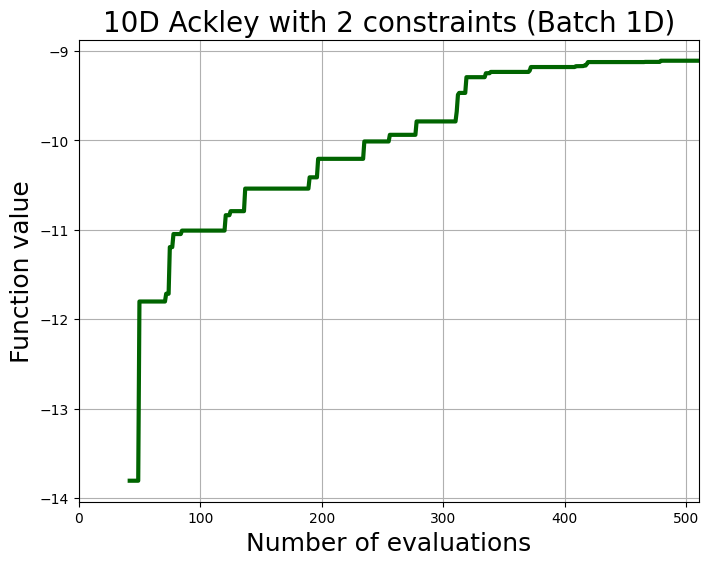

In [14]:
import matplotlib.pyplot as plt

# Evaluate optimization
batch_size = 1 * fun.dim
n_init = int(10)
max_budget = 500
N_CANDIDATES = 2000 # Number of candidates used during the Thompson sampling

# First generate initial DoE
X_ini = SobolEngine(dimension=fun.dim, scramble=True, seed=1).draw(n=n_init).to(**tkwargs)

# Run optimization loop    
X_all, Y_all, C_all = furbo_optimize(fun,
                                     eval_objective, 
                                     eval_constraints,
                                     X_ini,
                                     batch_size = batch_size,
                                     n_init = n_init,
                                     max_budget = max_budget,
                                     N_CANDIDATES = N_CANDIDATES) 

# Print optimization result
print_results(X_all, Y_all, C_all)

# Plotting monotic convergence curve
fig, ax = plt.subplots(figsize=(8, 6))
plot_results(ax, "darkgreen", Y_all, C_all)

# Adding description
plt.ylabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("10D Ackley with 2 constraints (Batch 1D)", fontsize=20)
plt.xlim([0, len(Y_all)])

plt.grid(True)
plt.show()

## Comparison with SCBO

In this section, we compare the performance of SCBO [2] and FuRBO in two scenarios:
1. 20D Ackley function with 2 cosntraints and large batch (batch size = 3D = 60)
2. Speed reducer volume minimization problem [4], a severely constrained black-box problem (7 dimensions and 11 constraints).

For a more in-depth comparison of FuRBO with other algorithms, please refer to [1] or to the data published on [GitHub](https://github.com/paoloascia/FuRBO).

[1] [Paolo Ascia, Elena Raponi, Thomas Bäck and Fabian Duddeck. "Feasibility-Driven Trust Region Bayesian Optimization." In AutoML 2025 Methods Track.](https://doi.org/10.48550/arXiv.2506.14619)

[2] [David Eriksson and Matthias Poloczek. Scalable constrained Bayesian optimization. In International Conference on Artificial Intelligence and Statistics, pages 730–738. PMLR, 2021.](https://doi.org/10.48550/arxiv.2002.08526)

[4] [Afonso C.C. Lemonge, Helio J.C. Barbosa, Carlos C.H. Borges and Francilene B.S. Silva. "Constrained optimization problems in mechanical engineering design using a real-coded steady-state genetic algorithm." Mecánica Computacional, 29(95):9287–9303, 2010.](http://venus.ceride.gov.ar/ojs/index.php/mc/article/viewFile/3669/3581)

### SCBO class and other utility functions

In [15]:
class ScboState():
    '''
    Class to track SCBO optimization state and update it with newly evaluated samples

    Args:
        fcn: objective function class
        batch_size: batch size
        n_init: number of initial points to evaluate
        n_iteration: number of total iterations
        
    '''
    # Initialization of the status
    def __init__(self, fcn, batch_size, n_init, max_budget, **tkwargs):
        
        # Domain bounds
        self.lb, self.ub = fcn.bounds
        self.bounds = fcn.bounds
        
        # Problem dimensions
        self.batch_size: int = batch_size      # Dimension of the batch at each iteration
        self.n_init: int = n_init              # Number of initial samples
        self.dim: int = fcn.dim                # Dimension of the problem
        
        # Trust regions information                 # Lower bounds of trust region
        self.tr_length: float = 0.8            # side length of trust region
        self.tr_length_max: float = 0.8
        self.tr_lb = torch.clamp(0.5*torch.ones(self.dim, **tkwargs) - self.tr_length / 2.0, 0.0, 1.0)
        self.tr_ub = torch.clamp(0.5*torch.ones(self.dim, **tkwargs) + self.tr_length / 2.0, 0.0, 1.0)
        self.tr_vol = torch.prod(self.tr_ub - self.tr_lb)

        # Trust region updating 
        self.failure_counter: int = 0       # Counter for failure points to asses how algorithm is going
        self.success_counter: int = 0       # Counter for success points to asses how algorithm is going
        self.success_tolerance: int = 2     # Success tolerance  
        self.failure_tolerance: int = 3     # Failure tolerance 
        
        # Tensor to save current batch information
        self.batch_X: Tensor        # Current batch to evaluate: X values
        self.batch_Y: Tensor        # Current batch to evaluate: Y value
        self.batch_C: Tensor        # Current batch to evaluate: C values
            
        # Stopping criteria information
        self.it_counter: int = 0                # Counter for iterations
        self.n_counter: int = 0                 # Counter for samples evaluated
        self.max_budget: int = max_budget       # Maximum number of evaluations allowed
        self.finish_trigger: bool = False       # Trigger to stop optimization
        
        # Restart criteria information
        self.tr_length_min: float = 0.5**7         # Minimum volume allowed for trust region
        self.restart_trigger: bool = False         # Trigger to stop optimization
        
        # Sobol sampler engine
        self.sobol = SobolEngine(dimension=self.dim, scramble=True, seed=1)
        
    # Update the status
    def update(self, X_next, Y_next, C_next, **tkwargs):
        '''
        Function to update optimization status
        
        Args:
            X_next: samples X (input values) to update the status
            Y_next: samples Y (objective value) to update the status
            C_next: Samples C (constraints values) to update the status

        '''
        
        # Merge current batch with previously evaluated samples
        if not hasattr(self, 'X'):
            # If there are no previous samples, declare the Tensors
            self.X = X_next
            self.Y = Y_next
            self.C = C_next
        else:
            # Else, concatenate the new batch to the previous samples
            self.X = torch.cat((self.X, X_next), dim=0)
            self.Y = torch.cat((self.Y, Y_next), dim=0)
            self.C = torch.cat((self.C, C_next), dim=0)

        # update GPR surrogates
        self.Y_model = get_fitted_model(self.X, self.Y, self.dim)
        self.C_model = ModelListGP(*[get_fitted_model(self.X, C.reshape(-1, 1), self.dim) for C in self.C.t()])
        
        # Update batch information 
        self.batch_X = X_next
        self.batch_Y = Y_next
        self.batch_C = C_next
            
        # Update best value
        # Find the best value among the candidates
        best_id = get_best_index_for_batch(n_tr=1, Y=self.Y, C=self.C)
            
        # Update success and failure counters for trust region update
        # If attribute 'best_X' does not exist, DoE was just evaluated -> no update on counters
        if hasattr(self, 'best_X'):
            if (self.C[best_id] <= 0).all():
                # At least one new candidate is feasible
                if (self.Y[best_id] > self.best_Y).any() or (self.best_C > 0).any():
                    self.success_counter += 1
                    self.failure_counter = 0                
                else:
                    self.success_counter = 0
                    self.failure_counter += 1
            else:
                # No new candidate is feasible
                total_violation_next = self.C[best_id].clamp(min=0).sum(dim=-1)
                total_violation_center = self.best_C.clamp(min=0).sum(dim=-1)
                if total_violation_next < total_violation_center:
                    self.success_counter += 1
                    self.failure_counter = 0
                else:
                    self.success_counter = 0
                    self.failure_counter += 1
        
        # Update best values
        self.best_X = self.X[best_id]
        self.best_Y = self.Y[best_id]
        self.best_C = self.C[best_id]
        
        # Update iteration counter
        self.it_counter += 1
        self.n_counter += len(Y_next)
        
    def reset_status(self, **tkwargs):
        '''Function to reset the status for the restart'''
        
        # Reset trust regions size
        self.tr_length: float = 0.8            # side length of trust region
        self.tr_length_max: float = 0.8
        self.tr_lb = torch.clamp(0.5*torch.ones(self.dim, **tkwargs) - self.tr_length / 2.0, 0.0, 1.0)
        self.tr_ub = torch.clamp(0.5*torch.ones(self.dim, **tkwargs) + self.tr_length / 2.0, 0.0, 1.0)
        self.tr_vol = torch.prod(self.tr_ub - self.tr_lb)

        # Reset counters to change trust region size 
        self.failure_counter: int = 0    # Counter of failure points to asses how algorithm is going
        self.success_counter: int = 0    # Counter of success points to asses how algorithm is going
        
        # Reset restart criteria trigger
        self.restart_trigger: bool = False      # Trigger to restart optimization
        
        # Delete tensors with samples for training GPRs
        if hasattr(self, 'X'):
            del self.X
            del self.Y
            del self.C
        
        # Delete tensors with best value so far
        if hasattr(self, 'best_X'):
            del self.best_X
            del self.best_Y
            del self.best_C
        
        # Clear GPU memory
        if tkwargs["device"] == "cuda":
            torch.cuda.empty_cache()  

def scbo_update_tr(state, **tkwargs):
    """
    Function to update the side length of the trust region

    Args:
        state: ScboState object

    """
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.tr_length = min(2.0 * state.tr_length, state.tr_length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.tr_length /= 2.0
        state.failure_counter = 0
        
    state.tr_lb = torch.clamp(state.best_X - state.tr_length / 2.0, 0.0, 1.0)
    state.tr_ub = torch.clamp(state.best_X + state.tr_length / 2.0, 0.0, 1.0)

    state.tr_vol = torch.prod(state.tr_ub - state.tr_lb)
    return state

def scbo_generate_batch(state, n_candidates, **tkwargs):
    """
    Function to compute next candidate to evaluate

    Args:
        state: ScboState object
        n_candidates: number of candidates inspecting the surrogates

    """

    assert state.X.min() >= 0.0 and state.X.max() <= 1.0 and torch.all(torch.isfinite(state.Y))

    # Create the TR bounds
    tr_lb = state.tr_lb
    tr_ub = state.tr_ub

    # Thompson Sampling w/ Constraints (SCBO)
    dim = state.X.shape[-1]
    pert = state.sobol.draw(n_candidates).to(dtype=tkwargs['dtype'], device=tkwargs['device'])
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / dim, 1.0)
    mask = torch.rand(n_candidates, dim, **tkwargs) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=tkwargs['device'])] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = state.best_X.expand(n_candidates, dim).clone()
    X_cand[mask] = pert[mask]

    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=state.Y_model, constraint_model=state.C_model, replacement=False
    )
    with torch.no_grad():
        X_next = constrained_thompson_sampling(X_cand, num_samples=state.batch_size)

    return X_next

def scbo_stopping_criterion(state):
    '''Function to evaluate if the maximum number of allowed iterations is reached.'''
    return state.n_counter > state.max_budget

def scbo_restart_criterion(state):
    '''Function to evaluate if the minimum side length of the trust region is reached.'''
    return state.tr_length < state.tr_length_min

def scbo_optimize(fcn, objective, constraints, X_ini, batch_size = 1, n_init = 10, max_budget = 200, N_CANDIDATES = 2000):
    '''Function to optimize an objective under a set of given constraints using SCBO
    
        Args:
            objective: handle to evaluate objective
            constraints: list of handles to evaluate constraints
            batch_size: size of the batch to evaluate at each iteration
            n_init: number of initial samples
            max_budget: maximum number of evaluations allowed

        Return:
            X_all: samples evaluated
            Y_all: objective values of the samples evaluated
            C_all: constraints values of the samples evaluated

    '''
    # SCBO state initialization
    state = ScboState(fcn,
                      batch_size = batch_size,          # Batch size of each iteration
                      n_init = n_init,                  # Number of initial points to evaluate
                      max_budget = max_budget,          # Number of iterations
                      **tkwargs)

    # Initiate lists to save samples over the restarts
    X_all, Y_all, C_all = [], [], []

    # Continue optimization the stopping criterions isn't triggered
    while not state.finish_trigger: 
    
        # Reset status for restarting
        state.reset_status(**tkwargs)
    
        # generate intial batch of X
        X_next = X_ini # Use same initial DoE of FuRBO
    
        # Reset and restart optimization
        while not state.restart_trigger and not state.finish_trigger:
                
            # Evaluate current batch (samples in X_next)
            Y_next = []
            C_next = []
            for x in X_next:
                # Evaluate batch on obj ...
                Y_next.append(objective(x))
                # ... and constraints
                C_next.append(constraints(x))
               
            # process vector for PyTorch
            Y_next = torch.stack(Y_next).unsqueeze(-1).to(**tkwargs)
            C_next = torch.stack(C_next).to(**tkwargs)
                
            # Update SCBO status with newly evaluated batch
            state.update(X_next, Y_next, C_next, **tkwargs)   
                
            # Printing current best
            # If a feasible has been evaluated -> print current optimum (feasible sample with best objective value)
            if (state.best_C <= 0).all():
                best = state.best_Y.amax()
                print(f"Samples evaluated: {state.n_counter} | Best value: {best:.2e},"
                      f" TR volume: {state.tr_vol}")
        
            # Else, if no feasible has been evaluated -> print smallest violation (the sample that violatest the least all constraints)
            else:
                violation = state.best_C.clamp(min=0).sum()
                print(f"Samples evaluated: {state.n_counter} | No feasible point yet! Smallest total violation: "
                      f"{violation:.2e}, TR volume: {state.tr_vol}")
            
            # Update Trust region
            state = scbo_update_tr(state, **tkwargs)
                
            # generate next batch to evaluate 
            X_next = scbo_generate_batch(state, N_CANDIDATES, **tkwargs)
        
            # Check if stopping criterion is met (budget exhausted and if GP failed)
            state.finish_trigger = scbo_stopping_criterion(state) 
        
            # Check if restart criterion is met
            state.restart_trigger = scbo_restart_criterion(state)

        # Save samples evaluated before resetting the status
        X_all.append(state.X)
        Y_all.append(state.Y)
        C_all.append(state.C)

    # Ri-elaborate for processing
    X_all = torch.cat(X_all)
    Y_all = torch.cat(Y_all)
    C_all = torch.cat(C_all)

    return X_all, Y_all, C_all

### Scenario 1: 20D Ackley function

The problem maximizes the Ackley function in 20D

In [16]:
fun20 = Ackley(dim=20, negate=True).to(**tkwargs)
fun20.bounds[0, :].fill_(-5)
fun20.bounds[1, :].fill_(10)

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun20(unnormalize(x, fun20.bounds))

With two constraint functions: 

$c_1 = \sum_{i=1}^{20} x_i \leq 0$

$c_2 = \| \mathbb{x}\|_2 \leq 0.5$

In [17]:
def c1(x):
    return x.sum()

def c2(x):
    return torch.norm(x, p=2) - 5
    
def eval_constraints(x):
    """This is a helper function we use to unnormalize and evalaute a point on the constraints"""
    return Tensor([c1(unnormalize(x - 0.3, fun20.bounds)), c2(unnormalize(x - 0.3, fun20.bounds))])

#### Evaluate algorithms

FuRBO on 20D Ackley function
Samples evaluated: 20 | No feasible point yet! Smallest total violation: 1.28e+01, MND radius: 1.0
Samples evaluated: 80 | No feasible point yet! Smallest total violation: 4.99e+00, MND radius: 1.0
Samples evaluated: 140 | No feasible point yet! Smallest total violation: 2.91e+00, MND radius: 1.0
Samples evaluated: 200 | No feasible point yet! Smallest total violation: 2.97e-01, MND radius: 1.0
Samples evaluated: 260 | Best value: -1.32e+01, MND radius: 1.0
Samples evaluated: 320 | Best value: -1.23e+01, MND radius: 1.0
Samples evaluated: 380 | Best value: -1.18e+01, MND radius: 1.0
Samples evaluated: 440 | Best value: -1.16e+01, MND radius: 1.0
Samples evaluated: 500 | Best value: -1.15e+01, MND radius: 1.0
Samples evaluated: 560 | Best value: -1.15e+01, MND radius: 1.0
Samples evaluated: 620 | Best value: -1.15e+01, MND radius: 1.0
Samples evaluated: 680 | Best value: -1.15e+01, MND radius: 1.0
Samples evaluated: 740 | Best value: -1.15e+01, MND radius: 0

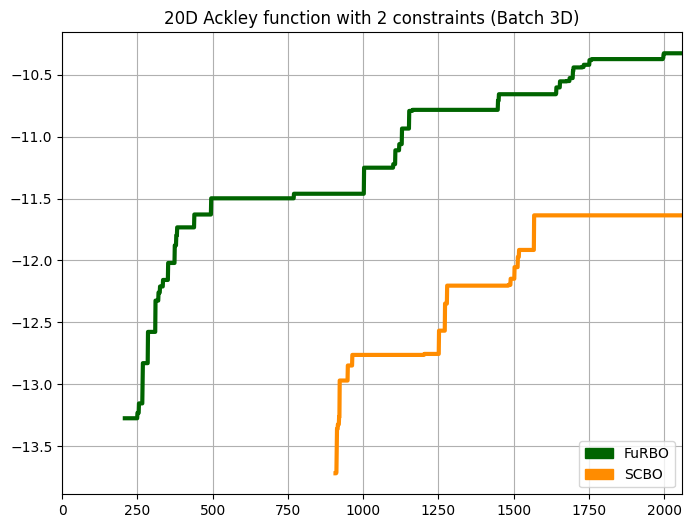

In [18]:
from matplotlib import patches

fig, ax = plt.subplots(figsize=(8, 6))

# Defining settings
batch_size = 3 * fun20.dim
n_init = fun20.dim
max_budget = 2000
N_CANDIDATES = 2000

# Generate initial DoE
X_ini = SobolEngine(dimension=fun20.dim, scramble=True, seed=1).draw(n=n_init).to(**tkwargs)

# Evaluate FuRBO optimization 
print("FuRBO on 20D Ackley function")
X_all, Y_all, C_all = furbo_optimize(fun20,
                                     eval_objective, 
                                     eval_constraints,
                                     X_ini,
                                     batch_size = batch_size,
                                     n_init = n_init,
                                     max_budget = max_budget,
                                     N_CANDIDATES = N_CANDIDATES) 

# Print optimization result
print_results(X_all, Y_all, C_all)

# Plot FuRBO convergence curve
plot_results(ax, "darkgreen", Y_all, C_all)

# Evaluate SCBO optimization 
print("\n SCBO on 20D Ackley function")
X_all, Y_all, C_all = scbo_optimize(fun20,
                                    eval_objective, 
                                     eval_constraints,
                                    X_ini,
                                    batch_size = batch_size,
                                    n_init = n_init,
                                    max_budget = max_budget,
                                    N_CANDIDATES = N_CANDIDATES) 

# Print optimization result
print_results(X_all, Y_all, C_all)

# Plot SCBO convergence curve
plot_results(ax, "darkorange", Y_all, C_all)

plt.xlim([0, len(Y_all)])

patchList = []
patchList.append(patches.Patch(color='darkgreen', label='FuRBO'))
patchList.append(patches.Patch(color='darkorange', label='SCBO'))
ax.legend(handles=patchList, loc='lower right')

ax.set_title("20D Ackley function with 2 constraints (Batch 3D)")

plt.grid(True)
plt.show()

### Scenario 2: Speed Reducer Objective function

The problem minimizes the weight $W$ of a speed reducer:

$W = 0.7854x_1x_2^2(3.3333x_e^2+14.9334x_3-43.0934)-1.508x_1(x_6^2+x_7^2)+7.4777(x_6^3+x_7^3)+0.7854(x_4x_6^2+x_5x_7^2)$

Under the following constraints:

$g_1(x) = 27x^{−1}_1 x^{−2}_2 x^{−1}_3 \leq 1$

$g_2(x)=397.5x^{−1}_1 x^{−2}_2 x^{−2}_3 \leq 1$

$g_3(x)=1.93x^{−1}_2 x^{−1}_3 x^3_4 x^{−4}_6 \leq 1$

$g_4(x)=1.93x^{−1}_2 x^{−1}_3 x^3_5 x^{−4}_7 \leq 1$

$g_5(x)= \frac{1}{0.1x^3_6} \sqrt{\left( \frac{745x_4}{x_2x_3} \right)^2 + 16.9 \cdot 10^6} \leq 1100$

$g_6(x)= \frac{1}{0.1x^3_7} \sqrt{\left( \frac{745x5}{x_2x_3} \right)^2 + 157.5 \cdot 10^6} \leq 850$

$g_7(x)=x_2x_3 \leq 40$

$g_8(x)=\frac{x_1}{x_2} \geq 5$

$g_9(x)=\frac{x_1}{x_2} \leq 12$

$g_{10}(x)=(1.5x_6 + 1.9)x^{−1}_4 \leq 1$

$g_{11}(x)=(1.1x_7 + 1.9)x^{−1}_5 \leq 1$

In [19]:
from botorch.test_functions.synthetic import SpeedReducer    

funS = SpeedReducer()

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return -1 * funS.evaluate_true(unnormalize(x, funS.bounds))

def eval_constraints(x):
    return -1 * funS.evaluate_slack_true(unnormalize(x, funS.bounds))

#### Evaluate algorithms

FuRBO on speed reducer problem
Samples evaluated: 10 | No feasible point yet! Smallest total violation: 1.47e-01, MND radius: 1.0
Samples evaluated: 17 | Best value: -3.63e+03, MND radius: 1.0
Samples evaluated: 24 | Best value: -3.11e+03, MND radius: 1.0
Samples evaluated: 31 | Best value: -3.11e+03, MND radius: 1.0
Samples evaluated: 38 | Best value: -3.11e+03, MND radius: 1.0
Samples evaluated: 45 | Best value: -3.11e+03, MND radius: 1.0
Samples evaluated: 52 | Best value: -3.06e+03, MND radius: 0.5
Samples evaluated: 59 | Best value: -3.06e+03, MND radius: 0.5
Samples evaluated: 66 | Best value: -3.06e+03, MND radius: 0.5
Samples evaluated: 73 | Best value: -3.04e+03, MND radius: 0.5
Samples evaluated: 80 | Best value: -3.04e+03, MND radius: 0.5
Samples evaluated: 87 | Best value: -3.04e+03, MND radius: 0.5
Samples evaluated: 94 | Best value: -3.04e+03, MND radius: 0.5
Samples evaluated: 101 | Best value: -3.04e+03, MND radius: 0.25
Samples evaluated: 108 | Best value: -3.04e+03, M

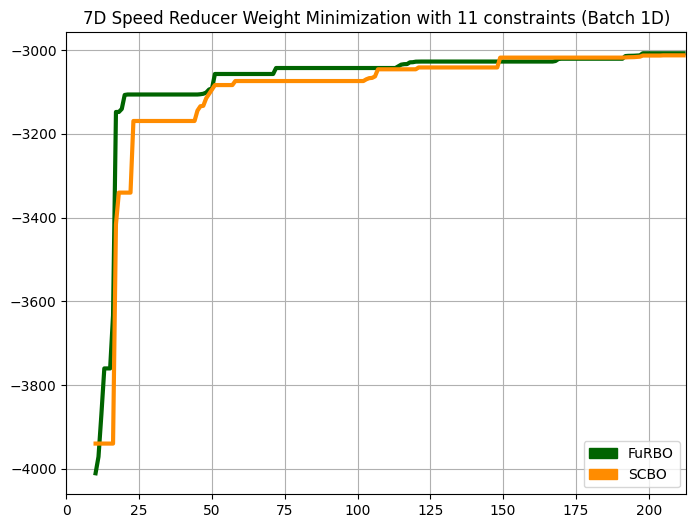

In [21]:
from matplotlib import patches

fig, ax = plt.subplots(figsize=(8, 6))

# Defining settings
batch_size = funS.dim
n_init = int(10)
max_budget = 210
N_CANDIDATES = 2000

# Generate initial DoE
X_ini = SobolEngine(dimension=funS.dim, scramble=True, seed=1).draw(n=n_init).to(**tkwargs)

# Evaluate FuRBO optimization 
print("FuRBO on speed reducer problem")
X_all, Y_all, C_all = furbo_optimize(funS,
                                     eval_objective, 
                                     eval_constraints,
                                     X_ini,
                                     batch_size = batch_size,
                                     n_init = n_init,
                                     max_budget = max_budget,
                                     N_CANDIDATES = N_CANDIDATES) 

# Print optimization result
print_results(X_all, Y_all, C_all)

# Plot FuRBO convergence curve
plot_results(ax, "darkgreen", Y_all, C_all)

# Evaluate SCBO optimization 
print("\n SCBO on speed reducer problem")
X_all, Y_all, C_all = scbo_optimize(funS,
                                    eval_objective, 
                                    eval_constraints,
                                    X_ini,
                                    batch_size = batch_size,
                                    n_init = n_init,
                                    max_budget = max_budget,
                                    N_CANDIDATES = N_CANDIDATES) 

# Print optimization result
print_results(X_all, Y_all, C_all)

# Plot SCBO convergence curve
plot_results(ax, "darkorange", Y_all, C_all)

plt.xlim([0, len(Y_all)])

patchList = []
patchList.append(patches.Patch(color='darkgreen', label='FuRBO'))
patchList.append(patches.Patch(color='darkorange', label='SCBO'))
ax.legend(handles=patchList, loc='lower right')

ax.set_title("7D Speed Reducer Weight Minimization with 11 constraints (Batch 1D)")

plt.grid(True)
plt.show()